# UE19CS390B – Capstone Project Phase – 2 #
# Interpretability of a joint learning problem by combining graph and text #

## Import Packages ##

In [1]:
import networkx as nx
import gzip
import ujson as json
import itertools
# import treelib
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx
import torch_geometric.utils.convert
from torch_geometric.loader import DataLoader
import pandas as pd
import torch

In [2]:
print(torch.__version__)


1.11.0


In [3]:
df1=pd.read_csv(r"C:\Users\91900\Capstone\cap-main\finalirmap.csv")
df1.dtypes

id             int64
created_at    object
text          object
text_info     object
dtype: object

In [4]:
df_all=pd.read_csv(r"C:\Users\91900\Capstone\cap-main\alldatasetspre.csv")
df_all

,label,text
0,informative,rt gizmodo wildfires raging northern californi...
1,informative,photos deadly wildfires rage california
2,informative,rt cal oes pls share capturing wildfire respon...
3,informative,rt cal oes pls share capturing wildfire respon...
4,informative,rt time california raging wildfires never seen
...,...,...
18077,not_informative,get mora try whole menu
18078,not_informative,mirka mora b 1928 noted french born australian...
18079,not_informative,paulmalignaggi lol u sergio mora horn winning
18080,not_informative,cameroon 4 female suicide bombers kill 1 mora


In [5]:
df1

,id,created_at,text,text_info
0,905625009430949888,Thu Sep 07 02:53:22 +0000 2017,island barbuda literally water hurricane irma,informative
1,905625059326353409,Thu Sep 07 02:53:34 +0000 2017,11pm hurricane irma update abc7news weather,informative
2,905625064451833856,Thu Sep 07 02:53:35 +0000 2017,hurricane irma destroys upwards 90 barbuda off...,informative
3,905625073628975106,Thu Sep 07 02:53:37 +0000 2017,5 pm track update hurricane irma flwx gawx jaxwx,informative
4,905625088300654592,Thu Sep 07 02:53:41 +0000 2017,11 pm advisory hurricane irma firstalertwx,informative
...,...,...,...,...
3515,910270036861886465,Tue Sep 19 22:31:03 +0000 2017,hurricane irma first impacts nassau bahamas 9 ...,informative
3516,910270462822895617,Tue Sep 19 22:32:45 +0000 2017,local resources irma,informative
3517,910270554812317697,Tue Sep 19 22:33:06 +0000 2017,whoa delta pull one last minute inbound flight...,informative
3518,910270595262291968,Tue Sep 19 22:33:16 +0000 2017,new story science amp health time cardi b comp...,not_informative


In [6]:
s='Tue Sep 19 15:47:08 +0000 2017'
ts_list = pd.to_datetime([s], infer_datetime_format=True)
#print(ts_list.values)
import dateutil.parser as parser
parser.parse(s)

def time_parser(ts):
    dobject=parser.parse(ts)
    return  dobject

In [7]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer


In [8]:
import torch

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Import BERT Model ##

In [9]:
output_dir = './model_save/'

bert = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
def getEmbed(text):
    
    marked_text = "[CLS] " + text + " [SEP]"

    tokenized_text = tokenizer.tokenize(marked_text)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)


    segments_ids = [1] * len(tokenized_text)
    
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    bert.eval()
    with torch.no_grad():

        outputs = bert(tokens_tensor, segments_tensors)

    
        hidden_states = outputs[1]
        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        res=sentence_embedding.numpy()
        return list(res)

## Create Conversation Graphs ##

In [11]:
import os
cwd=r"C:\Users\91900\Capstone\cap-main\convos"
data_arr=[]
for filename in os.listdir(cwd):
    fname=os.path.join(cwd, filename)
    data = pd.read_json(fname, lines=True)
    rootid=int(filename[:-6])
    r=df1.loc[df1['id']==rootid,['text','created_at','text_info']]
    t,c,label=r.values[0]
    d={}

    d[rootid]={'time': getEmbed(c),'text': getEmbed(t)}
    
    G=nx.DiGraph()
    G.add_node(rootid)
    for i in data['data'][0]:
        G.add_node(int(i['id']))
        d[int(i['id'])]={'time': getEmbed(i['created_at']),'text': getEmbed(i['text'])}
        G.add_edge(int(i['id']),int(i['referenced_tweets'][0]['id']))

    
    H = G.to_undirected()
    Gcc = sorted(nx.connected_components(H), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    G1=G0.to_directed()
    nx.set_node_attributes(G1, d)

    try:
        g_data=from_networkx(G1, group_node_attrs=['text', 'time'])

        g_data.y=0 if label=='informative' else 1
        data_arr.append(g_data)
    except:
        continue
    
        
print(len(data_arr))
    


320


In [12]:
dataset=data_arr
data=dataset[0]

In [13]:
print(dataset[110])

Data(edge_index=[2, 1], x=[2, 1536], y=0)


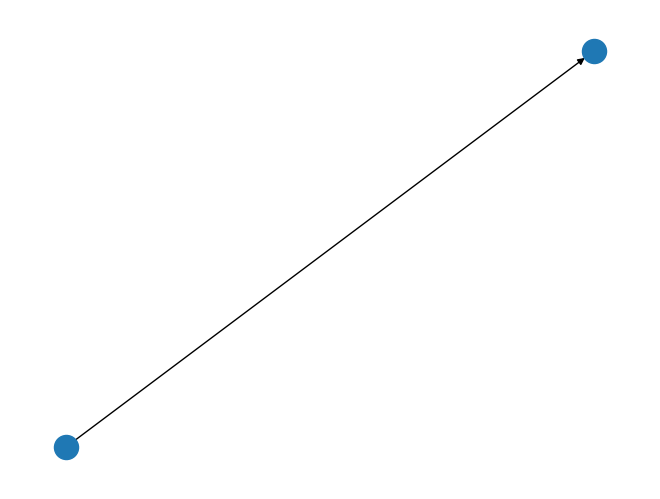

In [14]:
import networkx as nx
from torch_geometric.utils import to_networkx
G1 = to_networkx(dataset[110], to_undirected=False)
nx.draw(G1)

In [15]:
G1.nodes(data=True)

NodeDataView({0: {}, 1: {}})

In [16]:

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 4], x=[5, 1536], y=0)
Number of nodes: 5
Number of edges: 4
Average node degree: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: False


## Test-Train Split ##

In [17]:
import torch
from random import shuffle
torch.manual_seed(12345)
shuffle(dataset)

train_dataset = dataset[:198]
test_dataset = dataset[198:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 198
Number of test graphs: 122


In [18]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 160], x=[224, 1536], y=[64], batch=[224], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 333], x=[397, 1536], y=[64], batch=[397], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 159], x=[223, 1536], y=[64], batch=[223], ptr=[65])

Step 4:
Number of graphs in the current batch: 6
DataBatch(edge_index=[2, 17], x=[23, 1536], y=[6], batch=[23], ptr=[7])



## Graph Convolution Network ##

In [20]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GNNExplainer
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(456)
        self.fc=768
        self.conv1 = GCNConv(1536, 128)
        self.conv2 = GCNConv(128, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        self.emb=None
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  
        self.emb=x
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)

model1 = GCN(hidden_channels=64)
print(model1)

GCN(
  (conv1): GCNConv(1536, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


## Train Accuracy: 88.14 Test Accuracy: 73.81 ##

In [21]:
model1 = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model1.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model1(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model1.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model1(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
         print(pred)
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

total_sum1=0
total_sum2=0
for epoch in range(1, 51):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    total_sum1 = train_acc + total_sum1
    total_sum2 = test_acc + total_sum2
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
avg1 = total_sum1/50
avg2 = total_sum2/50
print(avg1, avg2)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Epoch: 009, Train Acc: 0.7929, Test Acc: 0.8197
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,

tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0,

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Epoch: 033, Train Acc: 0.8737, Test Acc: 0.8197
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0,

tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0,

## Graph Attention Network ##

In [22]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(1536, self.hid, heads=self.in_head, dropout=0.4)
        self.conv2 = GATConv(self.hid*self.in_head, 2, concat=False,
                             heads=self.out_head, dropout=0.4)



    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        emb=x
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.3, training=self.training)
        
        return F.log_softmax(x, dim=1)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT()

## Train Accuracy: 88.58 Test Accuracy: 77.74 ##

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print(out)
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         #print(out)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         #print(pred)
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

total_sum1=0
total_sum2=0
for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    total_sum1 = train_acc + total_sum1
    total_sum2 = test_acc + total_sum2
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
avg1 = total_sum1/100
avg2 = total_sum2/100
print(avg1, avg2)

Epoch: 001, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 002, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 003, Train Acc: 0.4646, Test Acc: 0.3607
Epoch: 004, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 005, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 006, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 007, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 008, Train Acc: 0.8131, Test Acc: 0.8197
Epoch: 009, Train Acc: 0.8081, Test Acc: 0.8197
Epoch: 010, Train Acc: 0.8182, Test Acc: 0.8197
Epoch: 011, Train Acc: 0.8182, Test Acc: 0.8197
Epoch: 012, Train Acc: 0.8131, Test Acc: 0.8197
Epoch: 013, Train Acc: 0.7929, Test Acc: 0.8197
Epoch: 014, Train Acc: 0.8081, Test Acc: 0.8197
Epoch: 015, Train Acc: 0.8131, Test Acc: 0.8197
Epoch: 016, Train Acc: 0.8081, Test Acc: 0.8197
Epoch: 017, Train Acc: 0.8131, Test Acc: 0.8197
Epoch: 018, Train Acc: 0.8687, Test Acc: 0.8443
Epoch: 019, Train Acc: 0.8687, Test Acc: 0.8361
Epoch: 020, Train Acc: 0.8182, Test Acc: 0.8197
Epoch: 021, Train Acc: 0.7980, Test Acc:

## Create Joint Dataset ##

In [24]:
df1=pd.read_csv(r"C:\Users\91900\Capstone\cap-main\finalirmap.csv")
df1['id']=df1['id'].astype('int64')
data_arr=[]
count=0
for filename in os.listdir(cwd):
    fname=os.path.join(cwd, filename)
    data = pd.read_json(fname, lines=True)
    conversation=json.load(fname)
    print(conversation)
    rootid=int(filename[:-6])
    r=df1.loc[df1['id']==rootid,['text','created_at','text_info']]
    #print(r)
    t,c,label=r.values[0]
    d={}

    d[rootid]={'time': getEmbed(c),'text': getEmbed(t)}
    
    G=nx.DiGraph()
    G.add_node(rootid)
    for i in data['data'][0]:
        G.add_node(int(i['id']))
        d[int(i['id'])]={'time': getEmbed(i['created_at']),'text': getEmbed(i['text'])}
        G.add_edge(int(i['id']),int(i['referenced_tweets'][0]['id']))
    
    H = G.to_undirected()
    Gcc = sorted(nx.connected_components(H), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    G1=G0.to_directed()
    nx.set_node_attributes(G1, d)

    try:

        g_data=from_networkx(G1, group_node_attrs=['text', 'time'])
        lab=0 if label=='informative' else 1
        g_data.y=lab
        data_arr.append((t,g_data,lab))
        count+=1
        print("done ",count)
        
    except:
        continue
print(data_arr[0])

                                                data  \
0  [{'author_id': '45648189', 'created_at': '2017...   

                                            includes  \
0  {'users': [{'profile_image_url': 'https://pbs....   

                                                meta  \
0  {'newest_id': '905661016985313281', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  1
                                                data  \
0  [{'possibly_sensitive': False, 'source': 'Twit...   

                                            includes  \
0  {'users': [{'username': 'ethanfleming69', 'pro...   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '906487760239845376', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/

done  13
                                                data  \
0  [{'possibly_sensitive': False, 'id': '90572319...   

                                            includes  \
0  {'users': [{'protected': False, 'id': '1541251...   

                                                meta  \
0  {'newest_id': '905723195566821376', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  14
                                                data  \
0  [{'referenced_tweets': [{'type': 'replied_to',...   

                                            includes  \
0  {'users': [{'profile_image_url': 'https://pbs....   

                                                meta  \
0  {'newest_id': '905726988287184896', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  15
                                                data  \
0  [{'lang': 'en', 

done  26
                                                data  \
0  [{'referenced_tweets': [{'type': 'replied_to',...   

                                            includes  \
0  {'users': [{'profile_image_url': 'https://abs....   

                                                meta  \
0  {'newest_id': '907005598880989185', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  27
                                                data  \
0  [{'possibly_sensitive': False, 'text': '@jwhit...   

                                            includes  \
0  {'users': [{'url': 'https://t.co/YZNPIfC7xU', ...   

                                                meta  \
0  {'newest_id': '905758399186575361', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  28
                                                data  \
0  [{'in_reply_to_u

done  44
                                                data  \
0  [{'possibly_sensitive': False, 'text': '@RSWar...   

                                            includes  \
0  {'users': [{'url': '', 'verified': False, 'cre...   

                                                meta  \
0  {'newest_id': '909746370935787520', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  45
                                                data  \
0  [{'in_reply_to_user_id': '3386209096', 'possib...   

                                            includes  \
0  {'users': [{'public_metrics': {'followers_coun...   

                                                meta  \
0  {'newest_id': '909488531357130752', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  46
                                                data  \
0  [{'id': '9094260

done  61
                                                data  \
0  [{'lang': 'en', 'author_id': '358419991', 'in_...   

                                            includes  \
0  {'users': [{'username': 'Lsubet', 'location': ...   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '909443882995392513', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  62
                                                data  \
0  [{'text': '@HealthyFla @AnastasiaMCD https://t...   

                                            includes  \
0  {'users': [{'created_at': '2010-02-15T05:51:27...   

                                                meta  \
0  {'newest_id': '909943276580388864', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.tw

done  77
                                                data  \
0  [{'author_id': '294229171', 'created_at': '201...   

                                            includes  \
0  {'users': [{'profile_image_url': 'https://pbs....   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '910739634187063296', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  78
                                                data  \
0  [{'referenced_tweets': [{'type': 'replied_to',...   

                                            includes  \
0  {'users': [{'entities': {'url': {'urls': [{'st...   

                                                meta  \
0  {'newest_id': '909472888717217792', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.tw

done  95
                                                data  \
0  [{'in_reply_to_user_id': '187318645', 'entitie...   

                                            includes  \
0  {'users': [{'entities': {'url': {'urls': [{'st...   

                                                meta  \
0  {'newest_id': '1152536670555627526', 'oldest_i...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  96
                                                data  \
0  [{'conversation_id': '909708627866513409', 'en...   

                                            includes  \
0  {'users': [{'public_metrics': {'followers_coun...   

                                                meta  \
0  {'newest_id': '909725839851491328', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  97
                                                data  \
0  [{'reply_setting

done  113
                                                data  \
0  [{'source': 'Twitter for iPhone', 'entities': ...   

                                            includes  \
0  {'users': [{'verified': False, 'description': ...   

                                                meta  \
0  {'newest_id': '909909180718489600', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  114
                                                data  \
0  [{'reply_settings': 'everyone', 'conversation_...   

                                            includes  \
0  {'users': [{'description': 'UPS On-Road Superv...   

                                                meta  \
0  {'newest_id': '909729225556537344', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  115
                                                data  \
0  [{'referenced

done  131
                                                data  \
0  [{'text': '.@EmilySlosberg @CommAbrams Why not...   

                                            includes  \
0  {'users': [{'pinned_tweet_id': '46924550625889...   

                                                meta  \
0  {'newest_id': '909813335092334592', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  132
                                                data  \
0  [{'lang': 'en', 'author_id': '261381719', 'pub...   

                                            includes  \
0  {'users': [{'description': 'Hand stamped creat...   

                                                meta  \
0  {'newest_id': '910371340749824002', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  133
                                                data  \
0  [{'lang': 'en

done  147
                                                data  \
0  [{'reply_settings': 'everyone', 'context_annot...   

                                            includes  \
0  {'users': [{'description': 'News News', 'publi...   

                                                meta  \
0  {'newest_id': '909890569740136449', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  148
                                                data  \
0  [{'public_metrics': {'retweet_count': 0, 'repl...   

                                            includes  \
0  {'users': [{'protected': False, 'url': '', 'na...   

                                                meta  \
0  {'newest_id': '909802213551128576', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  149
                                                data  \
0  [{'reply_sett

done  164
                                                data  \
0  [{'lang': 'und', 'author_id': '2286189025', 'p...   

                                            includes  \
0  {'users': [{'description': '#MMNAWG #MMIWG 
#M...   

                                              errors  \
0  [{'value': '709391233404239872', 'detail': 'Co...   

                                                meta  \
0  {'newest_id': '909862733004275714', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
                                                data  \
0  [{'conversation_id': '909823370342023169', 'id...   

                                            includes  \
0  {'users': [{'public_metrics': {'followers_coun...   

                                                meta  \
0  {'newest_id': '909833310322356224', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.co

done  180
                                                data  \
0  [{'created_at': '2017-09-19T00:52:06.000Z', 'p...   

                                            includes  \
0  {'media': [{'type': 'photo', 'url': 'https://p...   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '909943144946552832', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  181
                                                data  \
0  [{'text': '@pearkes bit niche, Ms. Desai', 'la...   

                                            includes  \
0  {'users': [{'pinned_tweet_id': '15435659565339...   

                                              errors  \
0  [{'resource_id': '909865490809421832', 'parame...   

                                                meta  \
0  {'newest_id': '90987

done  198
                                                data  \
0  [{'referenced_tweets': [{'type': 'replied_to',...   

                                            includes  \
0  {'users': [{'profile_image_url': 'https://pbs....   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '910987912275218433', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  199
                                                data  \
0  [{'reply_settings': 'everyone', 'text': '@Plan...   

                                            includes  \
0  {'users': [{'url': 'https://t.co/phBwPLSOFX', ...   

                                                meta  \
0  {'newest_id': '909921215070031872', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.

done  215
                                                data  \
0  [{'in_reply_to_user_id': '35342056', 'possibly...   

                                            includes  \
0  {'users': [{'public_metrics': {'followers_coun...   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '915409910829117440', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
                                                data  \
0  [{'created_at': '2017-09-19T00:50:37.000Z', 'p...   

                                            includes  \
0  {'users': [{'description': 'Recovering journal...   

                                                meta  \
0  {'newest_id': '909942774383996929', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.co

done  230
                                                data  \
0  [{'reply_settings': 'everyone', 'text': '@feat...   

                                            includes  \
0  {'users': [{'url': '', 'description': 'I love ...   

                                                meta  \
0  {'newest_id': '910034060059332608', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  231
                                                data  \
0  [{'author_id': '624039687', 'entities': {'anno...   

                                            includes  \
0  {'media': [{'media_key': '3_910048786600341505...   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '910048788999540736', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.

done  248
                                                data  \
0  [{'text': '@OrangeCoFL Mucha agua estancada. S...   

                                            includes  \
0  {'users': [{'created_at': '2009-10-23T20:47:36...   

                                                meta  \
0  {'newest_id': '910147265133719554', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  249
                                                data  \
0  [{'public_metrics': {'retweet_count': 0, 'repl...   

                                            includes  \
0  {'users': [{'protected': False, 'location': 'O...   

                                              errors  \
0  [{'value': '910149183881048064', 'detail': 'Co...   

                                                meta  \
0  {'newest_id': '910156604137463809', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.

done  265
                                                data  \
0  [{'possibly_sensitive': False, 'id': '91015832...   

                                            includes  \
0  {'users': [{'url': 'https://t.co/wMnXW9usd2', ...   

                                              errors  \
0  [{'parameter': 'entities.mentions.username', '...   

                                                meta  \
0  {'newest_id': '910158326503231489', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.twitter.com/2/tweets/sear...  
done  266
                                                data  \
0  [{'lang': 'en', 'reply_settings': 'everyone', ...   

                                            includes  \
0  {'users': [{'public_metrics': {'followers_coun...   

                                                meta  \
0  {'newest_id': '910165759959142404', 'oldest_id...   

                                             __twarc  
0  {'url': 'https://api.

KeyboardInterrupt: 

In [ ]:
darr=data_arr


In [ ]:
from interpret_text.experimental.common.utils_bert import Language, Tokenizer, BERTSequenceClassifier
from interpret_text.experimental.common.timer import Timer
from interpret_text.experimental.unified_information import UnifiedInformationExplainer
interpretBERT=torch.load('./model.ckpt')
interpretBERT
tokenizerIP=torch.load('./token.ckpt')
tokenizerIP
MAX_LEN=100

## Joint Model ##

In [ ]:
class Joint(torch.nn.Module):
    def __init__(self,bert,gnn):
        super(Joint,self).__init__()
        self.bert=bert
        self.gnn=gnn
        self.fc1=Linear(832,64)
        self.fc2=Linear(64,2)
    
    def forward(self,x1,x2):
        textemb=torch.tensor(getEmbed(x1))
        tokens_text = tokenizerIP.tokenize([str(x1).lower()])
        tokens_text, mask_text, _ = tokenizerIP.preprocess_classification_tokens(tokens_text, MAX_LEN)
        o1=interpretBERT.predict(token_ids=tokens_text,input_mask=mask_text, batch_size=64)
        o2=self.gnn(x2.x,x2.edge_index,batch=None)
        pred = o2.argmax(dim=1)  
        
        
        x = torch.cat([textemb, torch.tensor(self.gnn.emb[0])], dim=-1)
        x=self.fc1(F.relu(x))
        x=self.fc2(F.relu(x))
        return x,o1,pred
    

In [ ]:
for param in bert.parameters():
    param.requires_grad = False
for param in model1.parameters():
    param.requires_grad = False

jmodel=Joint(bert,model1)
print(jmodel)


In [ ]:
from sklearn.model_selection import train_test_split
X=[[a[0],a[1]] for a in darr ]
y=[a[2] for a in darr]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=jmodel.parameters(), lr=1e-3)



for epoch in range(5):
    running_loss = 0.0
    for i in range(len(X_train)):
        x1,x2=X_train[i]
        label=y_train[i]
        jmodel.train()

        optimizer.zero_grad()

        preds,_,_ = jmodel(x1, x2)
        
        loss = criterion(preds, torch.tensor(label))

        loss.requires_grad_(True)

        loss.backward()
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()
        if i % 50 == 49:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

In [ ]:
correct = 0
total = 0
correcttext=0
correctgraph=0
with torch.no_grad():
    for i in range(len(X_test)):
        x1,x2=X_test[i]
        label=y_test[i]
        outputs,textpred,graphpred = jmodel(x1,x2)
        
        _, predicted = torch.max(outputs.data, -1)
        
        total += 1
        correct += 1 if predicted.item()==label else 0
        
        textpred=textpred[0]
        correcttext+=1 if textpred==label else 0
        correctgraph += 1 if graphpred.item()==label else 0
        print(label,predicted,textpred,graphpred)

In [ ]:
x1,x2=X_test[-2]
label=y_test[-2]
outputs,textpred,graphpred = jmodel(x1,x2)

_, predicted = torch.max(outputs.data, -1)


print("Original Text:",x1[:])
print("True Label:",label)
print("Predicted Label by joint model:",predicted.item())
textpred=textpred[0]
print("Predicted Label by text model:",textpred)
print("Predicted Label by graph model:",graphpred.item())


In [ ]:
print(f'Accuracy of the Joint Model on the {total} test tweets: {100 * correct / total} %')
print(f'Accuracy of the Text model on the {total} test tweets: {100 * correcttext / total} %')
print(f'Accuracy of the Graph model on the {total} test tweets: {100 * correctgraph / total} %')


## Intepreting Text: BERT ##

In [ ]:
from interpret_text.experimental.widget import ExplanationDashboard
interpreter_unified = UnifiedInformationExplainer(model=interpretBERT.model, 
                                 train_dataset=list(df_all["text"]), 
                                 device=device, 
                                 target_layer=14, 
                                 classes=[0,1])
def interpretTextPred(text,pred_label):
    explanation_unified = interpreter_unified.explain_local(text, pred_label)
    ExplanationDashboard(explanation_unified)

In [ ]:
#interpretTextPred(x1,1)
explanation_unified = interpreter_unified.explain_local(x1, textpred)
ExplanationDashboard(explanation_unified)

## Interpreting Graph: GNNExplainer ##

In [ ]:
expl = GNNExplainer(model1, epochs=200, return_type='raw', log=False)


In [ ]:
x, edge_index = x2.x, x2.edge_index
node_feat_mask, edge_mask = expl.explain_graph(x, edge_index)

In [ ]:
ax, G = expl.visualize_subgraph(node_idx=None, edge_index=edge_index, edge_mask=edge_mask)
plt.show()